In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qnmfits

In [2]:
import pickle
import json

filename = 'SXS:BBH_ExtCCE_superrest:0305'

with open(f'{filename}.pickle', 'rb') as f:
    strain_data = pickle.load(f)
times = strain_data.pop('times')

with open(f'{filename}_metadata.json', 'r') as f:
    metadata = json.load(f)
    
sim = qnmfits.Custom(times, strain_data, metadata, zero_time=(2,2))

The effect of memory can be clearly seen in the plus polarization of the $h_{20}$ mode:

Text(0, 0.5, '$\\mathrm{Im}[h_{20}]$')

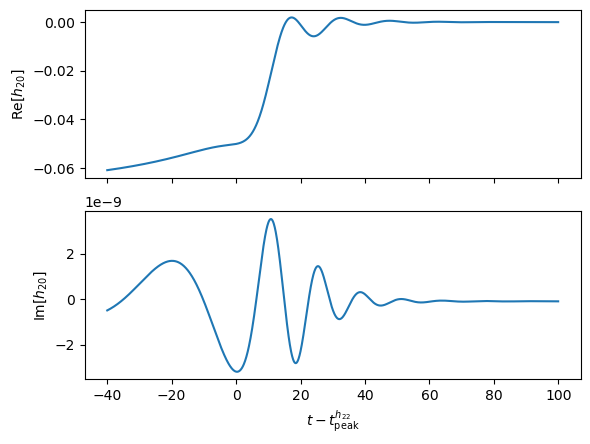

In [3]:
plot_mask = (sim.times > -40) & (sim.times < 100)

fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(sim.times[plot_mask], np.real(sim.h[2,0])[plot_mask])
axs[1].plot(sim.times[plot_mask], np.imag(sim.h[2,0])[plot_mask])

axs[1].set_xlabel('$t - t^{h_{22}}_\mathrm{peak}$')

axs[0].set_ylabel('$\mathrm{Re}[h_{20}]$')
axs[1].set_ylabel('$\mathrm{Im}[h_{20}]$')

We can get a reasonable fit to the waveform using the fundamental $(2,0,0,\pm)$ modes and the quadratic $220 \times 220$ mode, where the quadratic mode is constructed to have zero real part.

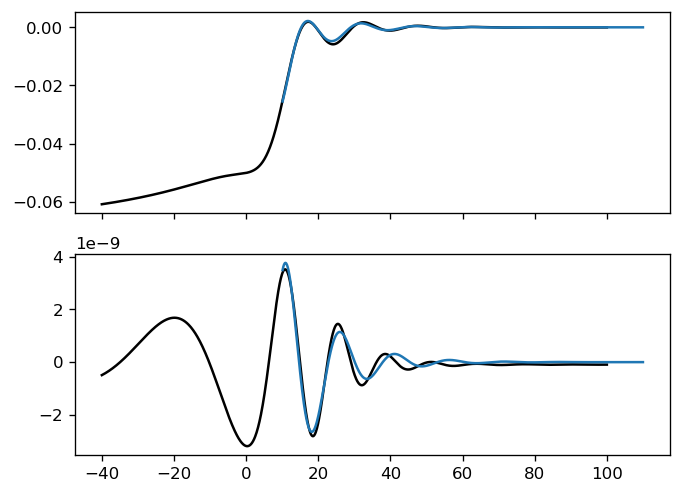

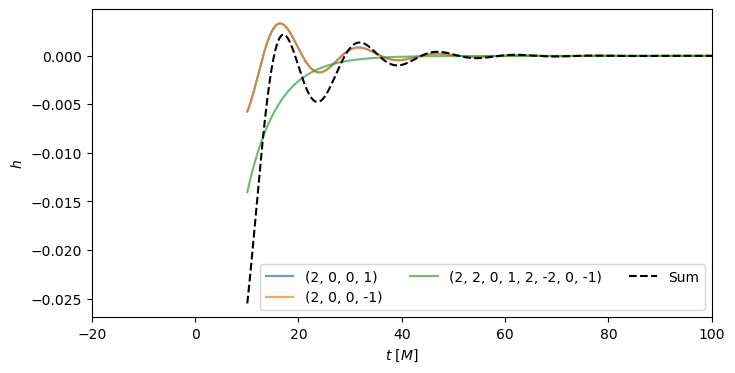

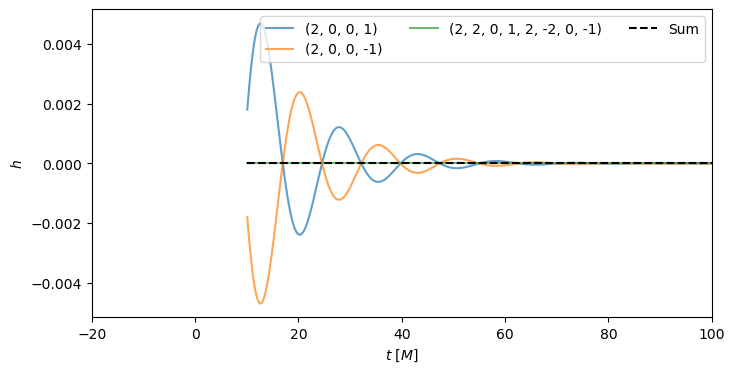

In [4]:
modes = [
    (2,0,0,1),
    (2,0,0,-1),
    (2,2,0,1,2,-2,0,-1),
    ]

best_fit = qnmfits.ringdown_fit(
    sim.times, 
    sim.h[2,0], 
    modes=modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=10
)

fig, axs = plt.subplots(2, sharex=True, dpi=120)

axs[0].plot(sim.times[plot_mask], np.real(sim.h[2,0])[plot_mask], c='k')
axs[0].plot(best_fit['model_times'], np.real(best_fit['model']))

axs[1].plot(sim.times[plot_mask], np.imag(sim.h[2,0])[plot_mask], c='k')
axs[1].plot(best_fit['model_times'], np.imag(best_fit['model']))

qnmfits.plot_ringdown_modes(
    best_fit,
    xlim=(-20,100), 
    legend=True
    )

qnmfits.plot_ringdown_modes(
    best_fit,
    plot_type='im',
    xlim=(-20,100), 
    legend=True
    )

Or we can get an even better fit with a bunch of overtones...

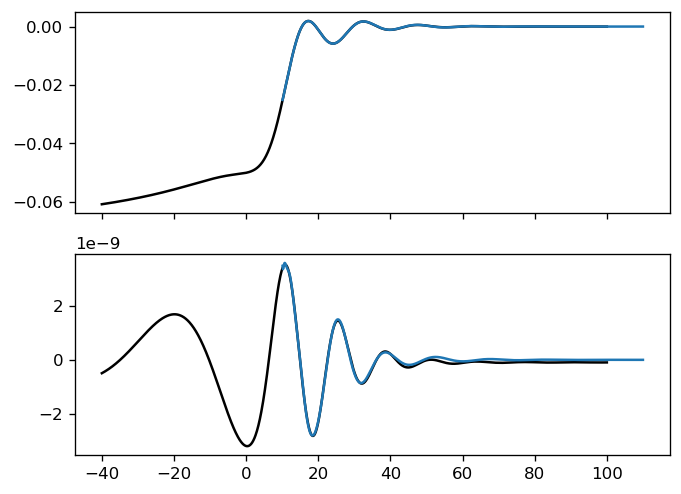

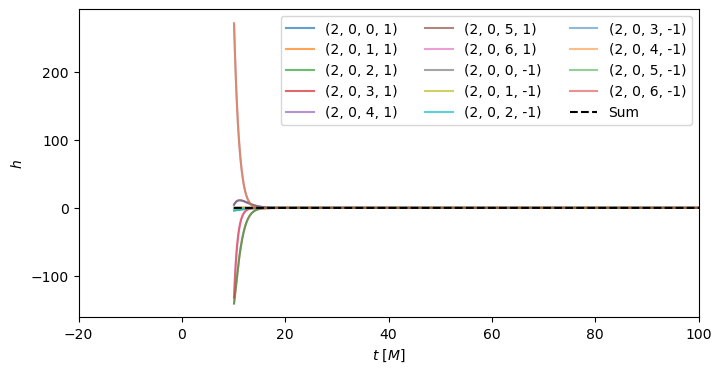

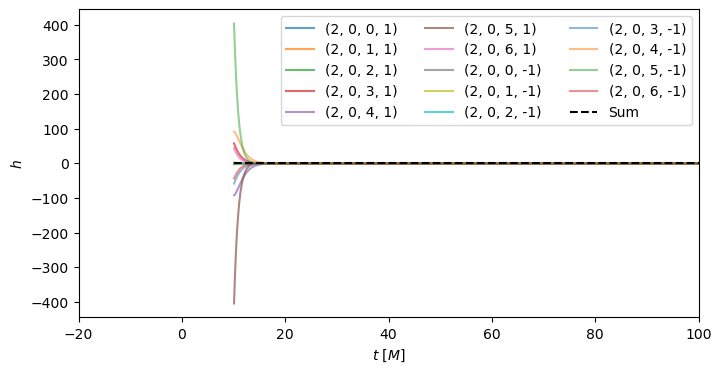

In [5]:
modes = [(2,0,n,1) for n in range(7)] + [(2,0,n,-1) for n in range(7)]

best_fit = qnmfits.ringdown_fit(
    sim.times, 
    sim.h[2,0], 
    modes=modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=10
)

fig, axs = plt.subplots(2, sharex=True, dpi=120)

axs[0].plot(sim.times[plot_mask], np.real(sim.h[2,0])[plot_mask], c='k')
axs[0].plot(best_fit['model_times'], np.real(best_fit['model']))

axs[1].plot(sim.times[plot_mask], np.imag(sim.h[2,0])[plot_mask], c='k')
axs[1].plot(best_fit['model_times'], np.imag(best_fit['model']))

qnmfits.plot_ringdown_modes(
    best_fit,
    xlim=(-20,100), 
    legend=True
    )

qnmfits.plot_ringdown_modes(
    best_fit,
    plot_type='im',
    xlim=(-20,100), 
    legend=True
    )

In [6]:
def delta_omega(omega_fit, omega_target):
    
    r_fit = np.real(omega_fit)
    i_fit = np.imag(omega_fit)
    
    r_target = np.real(omega_target)
    i_target = np.imag(omega_target)
    
    return np.sqrt(((r_fit-r_target)/r_target)**2 + ((i_fit-i_target)/i_target)**2)

def i_delta_omega(omega_fit, omega_target):
    
    i_fit = np.imag(omega_fit)
    i_target = np.imag(omega_target)
    
    return (i_fit-i_target)/i_target

In [7]:
omega_target = \
    qnmfits.qnm.omega(2, 2, 0, 1, sim.chif_mag, sim.Mf) \
    + qnmfits.qnm.omega(2, -2, 0, -1, sim.chif_mag, sim.Mf)

In [8]:
omega_fit_list = []
t0_list = np.linspace(0, 20)

for t0 in t0_list:
    omega_fit_list.append(qnmfits.free_frequency_fit(
        sim.times, 
        sim.h[2,0], 
        modes=[(2,0,0,1),(2,0,0,-1)], 
        Mf=sim.Mf, 
        chif=sim.chif_mag,
        t0=t0
    ))
    
omega_fit_list = np.array(omega_fit_list)

Text(0, 0.5, '$\\delta \\omega$')

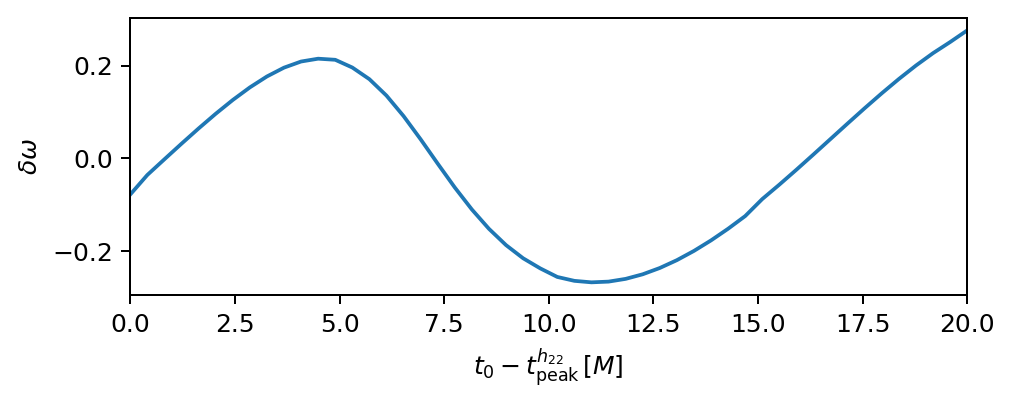

In [9]:
fig, ax = plt.subplots(figsize=(6,2), dpi=180)

ax.plot(t0_list, i_delta_omega(omega_fit_list, omega_target))

# ax.set_yscale('log')

ax.set_xlim(t0_list[0], t0_list[-1])

ax.set_xlabel('$t_0 - t_\mathrm{peak}^{h_{22}}\, [M]$')
ax.set_ylabel('$\delta \omega$')

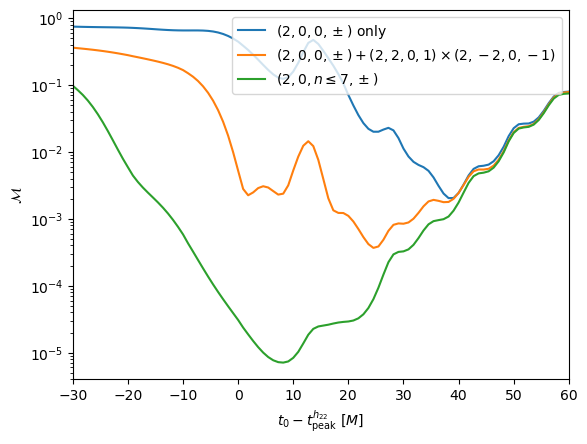

In [12]:
# The start times to use
t0_array = np.linspace(-30, 60, 100)

# Mode combinations
mode_dict = {
    '$(2,0,0,\pm)$ only': [(2,0,0,1),(2,0,0,-1)],
    r'$(2,0,0,\pm) + (2,2,0,1) \times (2,-2,0,-1)$': [(2,0,0,1),(2,0,0,-1), (2,2,0,1,2,-2,0,-1)],
    '$(2,0,n \leq 7,\pm)$': [(2,0,n,1) for n in range(7+1)] + [(2,0,n,-1) for n in range(7+1)],
}
    
    

# Create figure
fig, ax = plt.subplots(dpi=100)

for label, modes in mode_dict.items():
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        sim.times,
        sim.h[2,0],
        modes=modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0_array=t0_array
    )
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, label=label)
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')

_ = ax.legend()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 2117.79it/s]


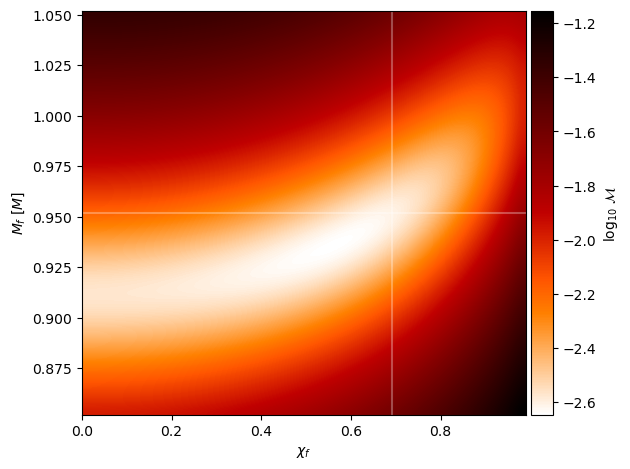

In [13]:
Mf_minmax = [sim.Mf-0.1, sim.Mf+0.1]
chif_minmax = [0, 0.99] # [sim.chif_mag-0.1, sim.chif_mag+0.1]

modes = [
    (2,0,0,1),
    (2,0,0,-1),
    ]

# We provide tuples for the mass and spin to define the grid boundaries
mm_grid = qnmfits.mismatch_M_chi_grid(
    sim.times,
    sim.h[2,0],
    modes,
    Mf_minmax=Mf_minmax, 
    chif_minmax=chif_minmax,
    t0=40
)

# There is a function to plot the result as a heatmap:
qnmfits.plot_mismatch_M_chi_grid(
    mm_grid,
    Mf_minmax,
    chif_minmax,
    truth=[sim.Mf,sim.chif_mag],
    fig_kw={'dpi':100}
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1926.67it/s]


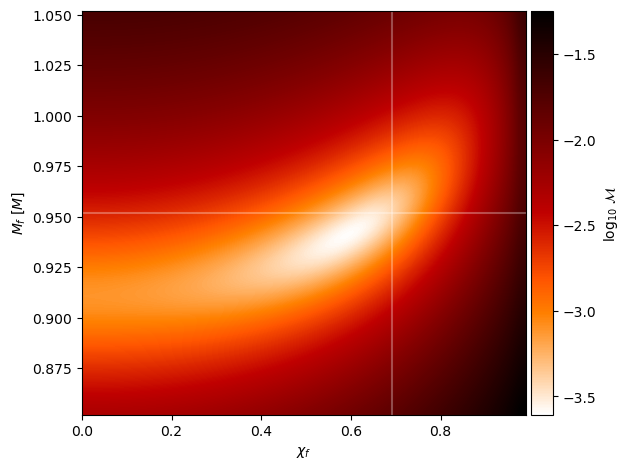

In [14]:
Mf_minmax = [sim.Mf-0.1, sim.Mf+0.1]
chif_minmax = [0, 0.99] # [sim.chif_mag-0.1, sim.chif_mag+0.1]

modes = [
    (2,0,0,1),
    (2,0,0,-1),
    (2,2,0,1,2,-2,0,-1),
    ]

# We provide tuples for the mass and spin to define the grid boundaries
mm_grid = qnmfits.mismatch_M_chi_grid(
    sim.times,
    sim.h[2,0],
    modes,
    Mf_minmax=Mf_minmax, 
    chif_minmax=chif_minmax,
    t0=25
)

# There is a function to plot the result as a heatmap:
qnmfits.plot_mismatch_M_chi_grid(
    mm_grid,
    Mf_minmax,
    chif_minmax,
    truth=[sim.Mf,sim.chif_mag],
    fig_kw={'dpi':100}
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 660.89it/s]


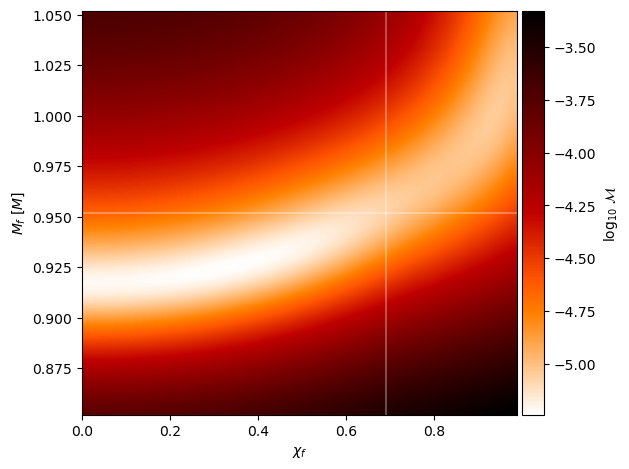

In [15]:
Mf_minmax = [sim.Mf-0.1, sim.Mf+0.1]
chif_minmax = [0, 0.99] # [sim.chif_mag-0.1, sim.chif_mag+0.1]

modes = [(2,0,n,1) for n in range(7+1)] + [(2,0,n,-1) for n in range(7+1)]

# We provide tuples for the mass and spin to define the grid boundaries
mm_grid = qnmfits.mismatch_M_chi_grid(
    sim.times,
    sim.h[2,0],
    modes,
    Mf_minmax=Mf_minmax, 
    chif_minmax=chif_minmax,
    t0=10
)

# There is a function to plot the result as a heatmap:
qnmfits.plot_mismatch_M_chi_grid(
    mm_grid,
    Mf_minmax,
    chif_minmax,
    truth=[sim.Mf,sim.chif_mag],
    fig_kw={'dpi':100}
)